# Masked vs Unmasked Depth Estimation with ZoeDepth

This notebook presents a controlled experiment to analyze how **image masking and bounding box cropping affect monocular depth estimation** using the **ZoeDepth** model.

## Objectives
- Compare depth predictions from:
  - Full outdoor images
  - Masked outdoor images
  - Cropped bounding-box images
- Evaluate the influence of:
  - Mask size
  - Background removal
- Analyze the effects using:
  - Visual depth maps and difference heatmaps
  - Statistical metrics and plots

## Dataset
A custom set of images including:
- Urban scenes
- Natural environments
- Scenes with few and many objects

## Purpose
This experiment supports our larger work on **monocular 3D localization**, helping us understand how local context and bounding regions influence depth prediction in outdoor environments.


## 1. Load outdoor image set and preview

In this step we:

- Define the main project folders:
  - `IMG_DIR` – the folder with our outdoor test images.
  - `OUT_DIR` – the folder where all experiment results will be saved.
- Create three subfolders inside `outputs`:
  - `depth_maps` – ZoeDepth outputs for each image.
  - `masked_images` – images after applying different masks and crops.
  - `plots` – comparison figures and graphs.
- Scan `IMG_DIR` and collect all `.png` images into a list called `image_paths`.
- Print how many outdoor images were found and their file names.
- Display **all images in two rows** to visually confirm:
  - Scene diversity
  - Object density variation
  - Correct path configuration

This cell only prepares the dataset and does not modify any images.


In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image

BASE_DIR = Path("experiments/bounding_box_exp")

IMG_DIR  = BASE_DIR / "data"
OUT_DIR  = BASE_DIR / "outputs"

# Subfolders for later results
DEPTH_DIR = OUT_DIR / "depth_maps"
MASK_DIR  = OUT_DIR / "masked_images"
PLOTS_DIR = OUT_DIR / "plots"

for d in [DEPTH_DIR, MASK_DIR, PLOTS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Collect all PNG images
EXTS = {".png"}
image_paths = [p for p in IMG_DIR.iterdir() if p.suffix.lower() in EXTS]
image_paths = sorted(image_paths)

print(f"Found {len(image_paths)} images in {IMG_DIR}:")
for i, p in enumerate(image_paths):
    print(f"{i}: {p.name}")

# Show all images in 2 rows
n = len(image_paths)
if n > 0:
    # 2 rows, enough columns to fit all images
    rows = 2
    cols = (n + 1) // 2  # ceil(n/2)

    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))

    # If there's only 1 row/col, make axes always a 2D array
    if rows == 1:
        axes = np.array([axes])
    if cols == 1:
        axes = axes.reshape(rows, 1)

    # Flatten for easier iteration
    axes_flat = axes.ravel()

    for ax, img_path in zip(axes_flat, image_paths):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(img_path.name, fontsize=8)
        ax.axis("off")

    # Hide any unused axes (if number of slots > number of images)
    for ax in axes_flat[n:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()
else:
    print("⚠ No PNG images found in", IMG_DIR)



FileNotFoundError: [WinError 3] The system cannot find the path specified: 'experiments\\bounding_box_exp\\data'

## 2. Bounding box and mask helpers

In this step we define two basic tools used throughout the experiment:

- `bbox_to_mask(image_size, bbox)`  
  Converts a bounding box `[x1, y1, x2, y2]` into a boolean mask where the inside of the box is `True` and everything else is `False`.

- `show_image_with_boxes(img_path, boxes, colors=None, title=None)`  
  Displays an image and draws one or more bounding boxes on top of it for visual verification.

These helpers provide a standard way to define regions of interest and visualize them before applying masking and depth analysis.


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def bbox_to_mask(image_size, bbox):
    """
    Create a boolean mask from a bounding box.
    
    image_size: (width, height)
    bbox: [x1, y1, x2, y2] in pixel coordinates
    
    Returns: mask of shape (height, width), dtype=bool
    """
    w, h = image_size
    x1, y1, x2, y2 = bbox

    mask = np.zeros((h, w), dtype=bool)
    mask[y1:y2, x1:x2] = True
    return mask


def show_image_with_boxes(img_path, boxes, colors=None, title=None):
    """
    Display an image with one or more bounding boxes drawn on it.
    
    img_path: Path to the image file
    boxes: list of [x1, y1, x2, y2]
    colors: list of colors (optional), same length as boxes
    """
    img = Image.open(img_path).convert("RGB")
    w, h = img.size

    if colors is None:
        # default: all boxes in red
        colors = ["red"] * len(boxes)

    fig, ax = plt.subplots(figsize=(6, 6 * h / w))
    ax.imshow(img)
    ax.axis("off")

    for bbox, color in zip(boxes, colors):
        x1, y1, x2, y2 = bbox
        rect = plt.Rectangle(
            (x1, y1),
            x2 - x1,
            y2 - y1,
            fill=False,
            edgecolor=color,
            linewidth=2
        )
        ax.add_patch(rect)

    if title is not None:
        ax.set_title(title)

    plt.tight_layout()
    plt.show()


## 3. Generate Geometric Masked Dataset

In this step, we generate the foundational dataset for our sensitivity analysis by applying fixed geometric masks to every image.

**What this code does:**
- **Creates Geometric Splits:** Automatically divides each image into 8 standard regions: Top/Bottom/Left/Right halves and 4 Quadrants.
- **Applies Black Masking:** Instead of cropping, we black out the irrelevant areas. This keeps the image size and perspective identical to the original, preventing the depth model from misinterpreting scale.
- **Saves Files:** The images are saved to the output directory with filenames containing their exact coordinates (`OriginalName_x1_y1_x2_y2.png`).
- **Verifies Output:** Displays 3 random examples to confirm the masking is correct.

Saving images to: C:\Users\noams\OneDrive\Desktop\school\final project\Z_Drone_Final_Project_GA\bounding_box_testing\outputs\masked_images
Starting generation...


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:03<00:00,  2.36it/s]



Done! Saved 64 images to 'C:\Users\noams\OneDrive\Desktop\school\final project\Z_Drone_Final_Project_GA\bounding_box_testing\outputs\masked_images'.
Displaying 3 random examples from the output folder:


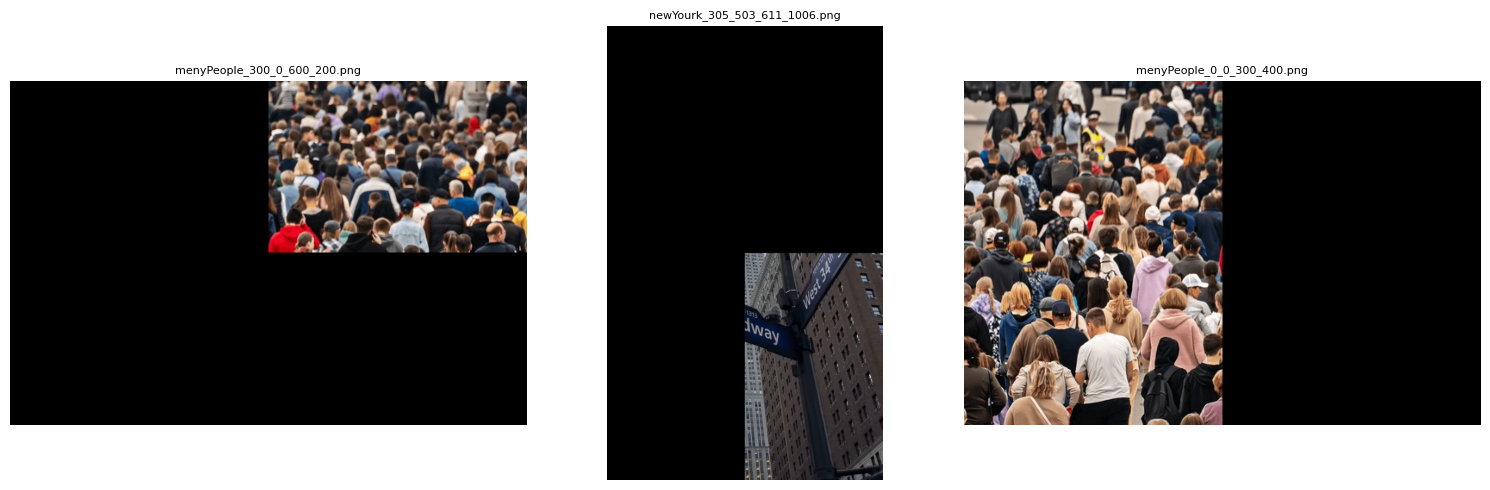

In [66]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

# --- 1. CONFIGURATION ---
# We use r"..." to ensure Windows backslashes are read correctly
OUTPUT_DIR = "experiments/bounding_box_exp/outputs/masked_images"

# Ensure the directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Saving images to: {OUTPUT_DIR}")

# --- 2. DEFINITIONS ---
def get_geometric_boxes(height, width):
    """Generates geometric splits (Halves and Fourths)."""
    mid_x, mid_y = width // 2, height // 2
    return {
        'top_half':    [0, 0, width, mid_y],
        'bottom_half': [0, mid_y, width, height],
        'left_half':   [0, 0, mid_x, height],
        'right_half':  [mid_x, 0, width, height],
        'quad_TL':     [0, 0, mid_x, mid_y],
        'quad_TR':     [mid_x, 0, width, mid_y],
        'quad_BL':     [0, mid_y, mid_x, height],
        'quad_BR':     [mid_x, mid_y, width, height]
    }

def apply_black_mask(image, box):
    """Creates a black canvas and copies the ROI from the original image."""
    img_arr = np.array(image)
    mask = np.zeros_like(img_arr)
    x1, y1, x2, y2 = box
    
    # Clip coordinates to image bounds to avoid errors
    h, w = img_arr.shape[:2]
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(w, x2), min(h, y2)
    
    mask[y1:y2, x1:x2] = img_arr[y1:y2, x1:x2]
    return Image.fromarray(mask)

# --- 3. GENERATION LOOP ---
# This assumes 'image_paths' is already defined in your notebook. 
# If not, ensure you run the cell that loads your image paths first.

generated_files = [] 

print("Starting generation...")
for img_path in tqdm(image_paths):
    try:
        # Handle filename extraction whether input is string or Path object
        if hasattr(img_path, 'stem'):
            base_name = img_path.stem
        else:
            base_name = os.path.splitext(os.path.basename(img_path))[0]

        with Image.open(img_path) as img:
            img = img.convert("RGB")
            w, h = img.size
            
            boxes = get_geometric_boxes(h, w)
            
            for label, box in boxes.items():
                masked_img = apply_black_mask(img, box)
                
                # Naming: Name_x1_y1_x2_y2.png (UPDATED)
                x1, y1, x2, y2 = box
                save_name = f"{base_name}_{x1}_{y1}_{x2}_{y2}.png"
                save_path = os.path.join(OUTPUT_DIR, save_name)
                
                masked_img.save(save_path)
                generated_files.append(save_path)
                
    except Exception as e:
        print(f"Error on {img_path}: {e}")

print(f"\nDone! Saved {len(generated_files)} images to '{OUTPUT_DIR}'.")

# --- 4. VERIFY 3 RANDOM EXAMPLES ---
if len(generated_files) > 0:
    print("Displaying 3 random examples from the output folder:")
    
    # Select 3 unique random files
    num_samples = min(3, len(generated_files))
    samples = random.sample(generated_files, num_samples)
    
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    if num_samples == 1: axes = [axes] # Handle single case

    for ax, fpath in zip(axes, samples):
        try:
            img = Image.open(fpath)
            ax.imshow(img)
            # Show just the filename, not the full path, to keep title clean
            ax.set_title(os.path.basename(fpath), fontsize=8)
            ax.axis('off')
        except Exception as e:
            ax.set_title(f"Error loading: {e}")

    plt.tight_layout()
    plt.show()
else:
    print("No images were generated. Please check your 'image_paths' list.")

## 4. Generate Random Masked Dataset

In this step, we expand the dataset with randomized samples to stress-test the model's sensitivity to scale and position:

- `Random Sampling`  
  We generate 15 unique bounding boxes per image with random sizes (20%–80%) and locations. This simulates unpredictable object placement and distance.

- `Duplicate Prevention`  
  The code explicitly checks new random boxes against the fixed "Geometric Splits" to ensure no data duplication occurs.

- `Visual Verification`  
  We generate a final visualization showing all 15 random boxes overlaid on the image, along with three examples of the resulting black-masked files to confirm the process.

--- Step 3.2: Generating Random Boxes ---


100%|██████████| 8/8 [00:04<00:00,  1.98it/s]


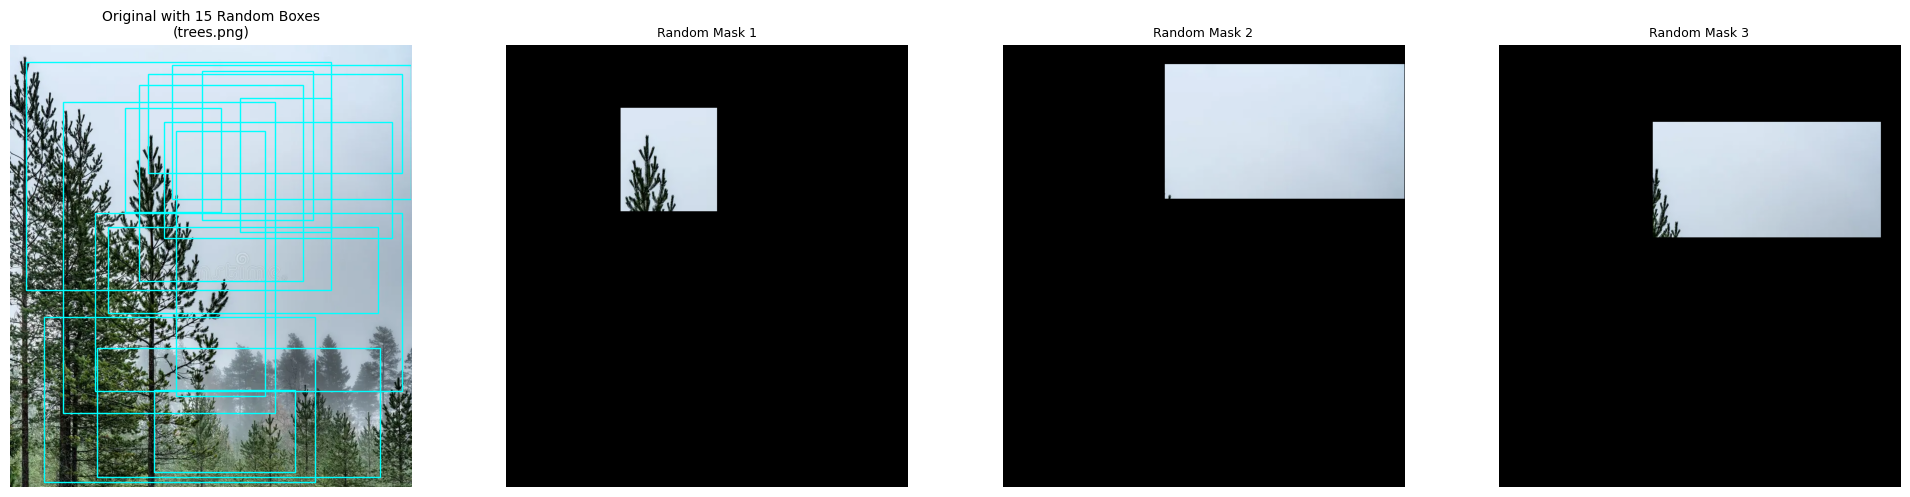

In [67]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from tqdm import tqdm

# --- 1. CONFIGURATION ---
OUTPUT_DIR = "experiments/bounding_box_exp/outputs/masked_images"
os.makedirs(OUTPUT_DIR, exist_ok=True)
NUM_BOXES = 15

# --- 2. HELPER FUNCTIONS ---

def get_geometric_boxes_list(w, h):
    """
    Returns the list of geometric boxes [x1, y1, x2, y2] used in Step 3.1.
    We need this to ensure our random boxes are not duplicates of these.
    """
    mid_x, mid_y = w // 2, h // 2
    return [
        [0, 0, w, mid_y],      # top_half
        [0, mid_y, w, h],      # bottom_half
        [0, 0, mid_x, h],      # left_half
        [mid_x, 0, w, h],      # right_half
        [0, 0, mid_x, mid_y],  # quad_TL
        [mid_x, 0, w, mid_y],  # quad_TR
        [0, mid_y, mid_x, h],  # quad_BL
        [mid_x, mid_y, w, h]   # quad_BR
    ]

def generate_unique_random_bboxes(image_size, num_boxes, min_size, max_size, forbidden_boxes):
    """
    Generates random boxes, ensuring they are NOT in the forbidden_boxes list.
    """
    w, h = image_size
    boxes = []
    attempts = 0
    max_attempts = num_boxes * 200 # Safety break
    
    while len(boxes) < num_boxes and attempts < max_attempts:
        attempts += 1
        
        bw = random.randint(min_size, max_size)
        bh = random.randint(min_size, max_size)
        
        # Ensure box fits in image
        if w - bw <= 0 or h - bh <= 0: continue

        x1 = random.randint(0, w - bw)
        y1 = random.randint(0, h - bh)
        x2 = x1 + bw
        y2 = y1 + bh
        
        new_box = [x1, y1, x2, y2]
        
        # CHECK 1: Is this box identical to a geometric split?
        if new_box in forbidden_boxes:
            continue
            
        # CHECK 2: Is this box identical to one we just generated?
        if new_box in boxes:
            continue
            
        boxes.append(new_box)
        
    return boxes

def apply_black_mask(image, box):
    """Creates a black canvas and copies the ROI."""
    img_arr = np.array(image)
    mask = np.zeros_like(img_arr)
    x1, y1, x2, y2 = box
    
    # Clip to bounds
    h, w = img_arr.shape[:2]
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(w, x2), min(h, y2)
    
    mask[y1:y2, x1:x2] = img_arr[y1:y2, x1:x2]
    return Image.fromarray(mask)

# --- 3. MAIN LOOP ---
print("--- Step 3.2: Generating Random Boxes ---")
viz_data = {} # For visualization

for idx, img_path in enumerate(tqdm(image_paths)):
    try:
        # Get base filename
        if hasattr(img_path, 'stem'): base_name = img_path.stem
        else: base_name = os.path.splitext(os.path.basename(img_path))[0]

        with Image.open(img_path) as img:
            img = img.convert("RGB")
            w, h = img.size
            
            # 1. Define Constraints (20% to 80% of min side)
            min_side = min(w, h)
            min_s = int(0.20 * min_side)
            max_s = int(0.80 * min_side)
            
            # 2. Get Forbidden List (Geometric Splits)
            forbidden = get_geometric_boxes_list(w, h)
            
            # 3. Generate Random Boxes (Unique)
            rand_boxes = generate_unique_random_bboxes((w, h), NUM_BOXES, min_s, max_s, forbidden)
            
            # Save for viz
            viz_data[idx] = {'path': img_path, 'boxes': rand_boxes, 'saved_files': []}
            
            # 4. Save Masks
            for box in rand_boxes:
                x1, y1, x2, y2 = box
                
                # Naming: OriginalName_x1_y1_x2_y2.png (Consistent with previous step)
                save_name = f"{base_name}_{x1}_{y1}_{x2}_{y2}.png"
                save_path = os.path.join(OUTPUT_DIR, save_name)
                
                # CHECK 3: Only create/save if file doesn't exist
                if not os.path.exists(save_path):
                    masked_img = apply_black_mask(img, box)
                    masked_img.save(save_path)
                
                viz_data[idx]['saved_files'].append(save_path)

    except Exception as e:
        print(f"Error {img_path}: {e}")

# --- 4. VISUALIZATION ---
# Logic: Show the LAST image processed with all its boxes + 3 mask examples
if viz_data:
    last_idx = list(viz_data.keys())[-1]
    data = viz_data[last_idx]
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # Plot 1: Original with ALL random boxes
    im_pil = Image.open(data['path'])
    axes[0].imshow(im_pil)
    axes[0].set_title(f"Original with {len(data['boxes'])} Random Boxes\n({os.path.basename(data['path'])})", fontsize=10)
    axes[0].axis('off')
    
    # Draw boxes
    for box in data['boxes']:
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='cyan', facecolor='none')
        axes[0].add_patch(rect)
        
    # Plot 2, 3, 4: Mask Examples
    # Filter available files (in case some didn't save or error)
    available_files = [f for f in data['saved_files'] if os.path.exists(f)]
    
    if len(available_files) >= 3:
        sample_files = random.sample(available_files, 3)
    else:
        sample_files = available_files
        
    for i, fpath in enumerate(sample_files):
        ax_idx = i + 1
        axes[ax_idx].imshow(Image.open(fpath))
        axes[ax_idx].set_title(f"Random Mask {i+1}", fontsize=9)
        axes[ax_idx].axis('off')
        
    plt.tight_layout()
    plt.show()
else:
    print("No data generated.")

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# --- 1. PREVIEW LOGIC (Function Definition) ---
def preview_last_manual_mask(inputs, all_paths):
    if not inputs:
        print("List is empty. Add a tuple (ID, [x1,y1,x2,y2]) below.")
        return

    # Get the last entry from the bottom of the list
    img_id, box = inputs[-1]
    
    if img_id < 0 or img_id >= len(all_paths):
        print(f"Error: Image ID {img_id} is out of range (0 to {len(all_paths)-1}).")
        return

    img_path = all_paths[img_id]
    
    try:
        with Image.open(img_path) as img:
            img = img.convert("RGB")
            
            # Create Black Mask
            img_arr = np.array(img)
            mask = np.zeros_like(img_arr)
            x1, y1, x2, y2 = box
            
            # Clip coords to image bounds
            h, w = img_arr.shape[:2]
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(w, x2), min(h, y2)
            
            # Copy ROI
            mask[y1:y2, x1:x2] = img_arr[y1:y2, x1:x2]
            
            # Display
            plt.figure(figsize=(6, 6))
            plt.imshow(mask)
            plt.title(f"Previewing Manual Box on Image {img_id}\n{img_path.name}\nBox: {box}")
            plt.axis('off')
            plt.show()
            
    except Exception as e:
        print(f"Error opening image: {e}")


# --- 2. YOUR INPUTS (Edit this list) ---
# Format: (IMAGE_ID, [x1, y1, x2, y2])
# The code will automatically visualize the LAST entry in this list.

MANUAL_INPUTS = [
    # Examples:
    # (0, [100, 100, 400, 400]),
    (0, [50, 50, 300, 300]),  # <--- Edit here and Run
]

preview_last_manual_mask(MANUAL_INPUTS, image_paths)

NameError: name 'image_paths' is not defined

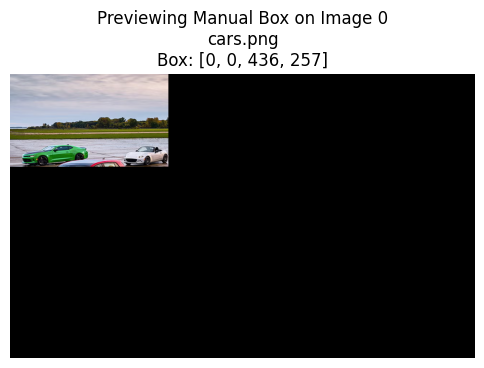

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# --- 1. PREVIEW LOGIC (Function Definition) ---
def preview_last_manual_mask(inputs, all_paths):
    if not inputs:
        print("List is empty. Add a tuple (ID, [Width, Height, X2, Y2]) below.")
        return

    # Get the last entry from the bottom of the list
    img_id, params = inputs[-1]
    
    if img_id < 0 or img_id >= len(all_paths):
        print(f"Error: Image ID {img_id} is out of range (0 to {len(all_paths)-1}).")
        return

    img_path = all_paths[img_id]
    
    try:
        with Image.open(img_path) as img:
            img = img.convert("RGB")
            
            # Create Black Mask
            img_arr = np.array(img)
            mask = np.zeros_like(img_arr)
            
            # --- NEW LOGIC: [Width, Height, X2, Y2] ---
            w_box, h_box, x2, y2 = params
            
            # Calculate x1, y1 based on bottom-right
            x1 = x2 - w_box
            y1 = y2 - h_box
            
            # For display purposes
            calculated_box = [x1, y1, x2, y2]
            
            # Clip coords to image bounds
            h_img, w_img = img_arr.shape[:2]
            x1 = max(0, int(x1))
            y1 = max(0, int(y1))
            x2 = min(w_img, int(x2))
            y2 = min(h_img, int(y2))
            
            # Copy ROI
            mask[y1:y2, x1:x2] = img_arr[y1:y2, x1:x2]
            
            # Display
            plt.figure(figsize=(6, 6))
            plt.imshow(mask)
            plt.title(f"Previewing Image {img_id}\nParams [W, H, X2, Y2]: {params}\nCalculated Box: {calculated_box}")
            plt.axis('off')
            plt.show()
            
    except Exception as e:
        print(f"Error opening image: {e}")


# --- 2. YOUR INPUTS (Edit this list) ---
# Format: (IMAGE_ID, [Width, Height, X2, Y2])
# X2, Y2 = The Bottom-Right corner coordinate
# Width, Height = How big the box is, expanding UP and LEFT from that corner.

MANUAL_INPUTS = [
    # Examples:
    # (0, [100, 100, 400, 400]),
    (0, [30, 180, 230, 280]),  # <--- Edit here and Run
    (0, [0, 220, 400, 415]),  # <--- Edit here and Run
    (0, [185, 285, 586, 612]),  # <--- Edit here and Run
        (0, [0, 0, 436, 257]),  # <--- Edit here and Run



]

preview_last_manual_mask(MANUAL_INPUTS, image_paths)

Processing 10 comparisons...


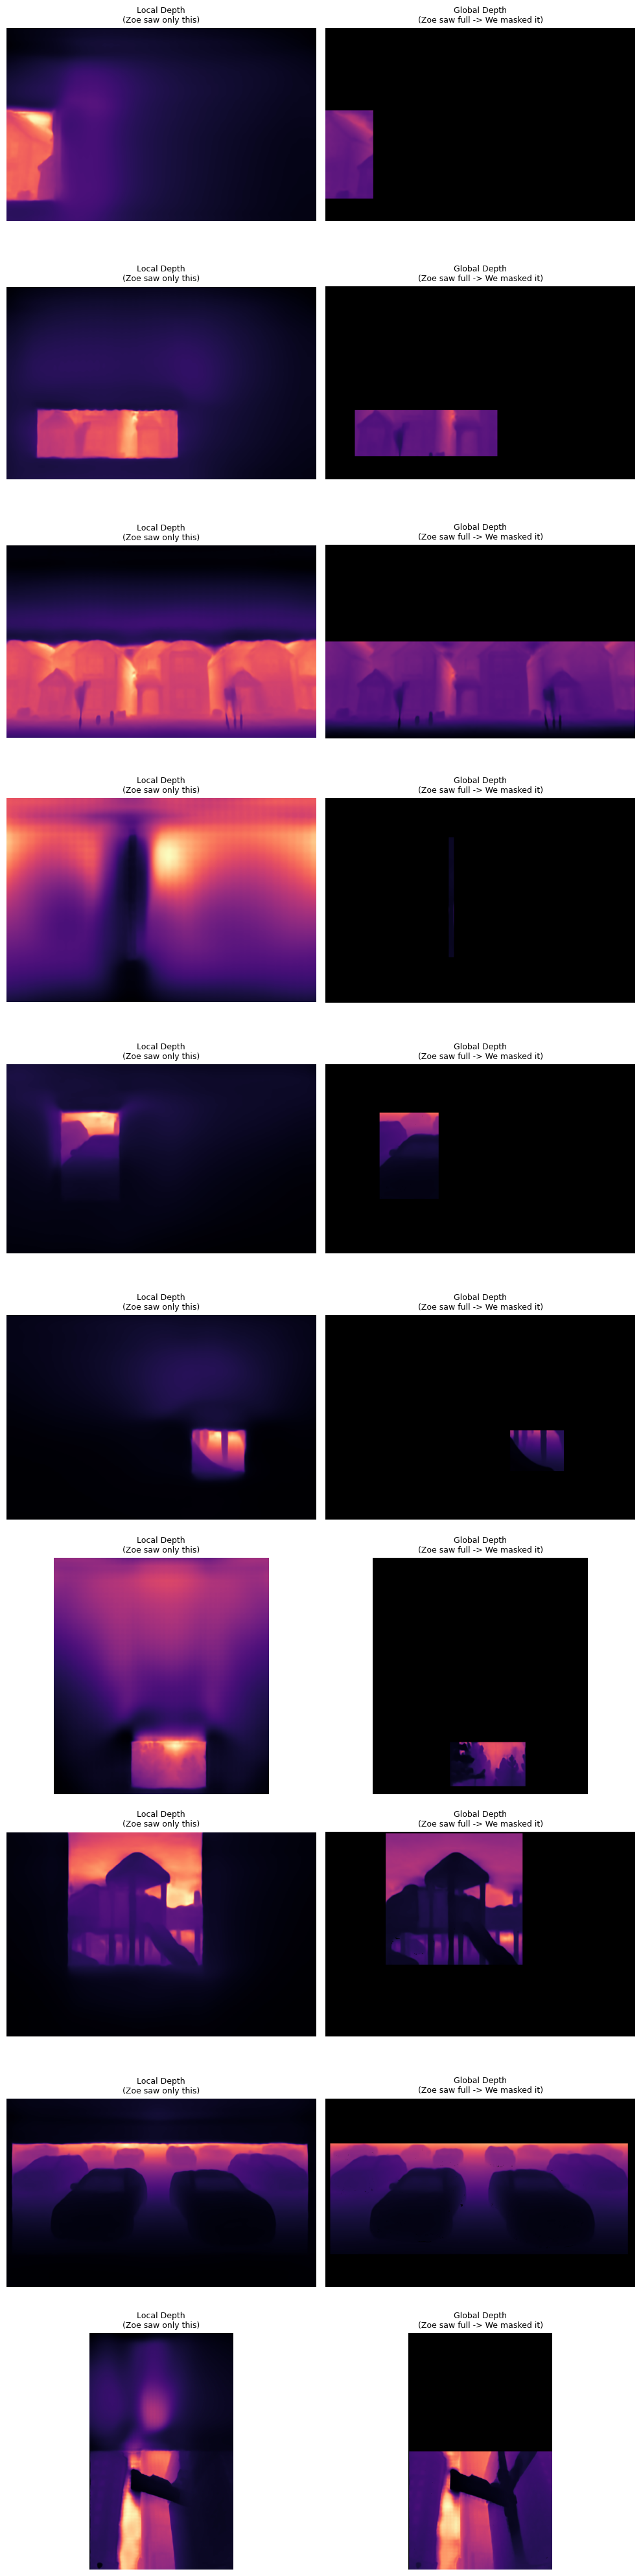

In [11]:
import os
import random
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- 1. SETUP PATHS ---
# Path to the INPUT masked images (Used to find the mask shape/location)
MASKED_IMAGES_DIR = r"C:\Users\noams\OneDrive\Desktop\school\final project\Z_Drone_Final_Project_GA\experiments\bounding_box_exp\outputs\masked_images"

# Path to the OUTPUT depth maps (Contains both Local and Global results)
DEPTH_MAPS_DIR = r"C:\Users\noams\OneDrive\Desktop\school\final project\Z_Drone_Final_Project_GA\experiments\bounding_box_exp\outputs\depth_maps"

def compare_using_original_masks():
    # Check directories
    if not os.path.exists(MASKED_IMAGES_DIR) or not os.path.exists(DEPTH_MAPS_DIR):
        print("Error: One of the directories was not found.")
        return

    # Get all masked image files
    valid_exts = ('.png', '.jpg', '.jpeg')
    masked_files = [f for f in os.listdir(MASKED_IMAGES_DIR) if f.lower().endswith(valid_exts)]
    
    # Pick 10 random images
    num_samples = min(10, len(masked_files))
    if num_samples == 0:
        print("No images found in masked_images folder.")
        return
        
    selected_files = random.sample(masked_files, num_samples)
    print(f"Processing {num_samples} comparisons...")

    # Setup Plot
    fig, axes = plt.subplots(nrows=num_samples, ncols=2, figsize=(10, 4 * num_samples))
    if num_samples == 1: axes = [axes]

    # Regex to extract the base name (removes the coordinates)
    # Matches: Name_x1_y1_x2_y2.ext -> Group 1 is "Name"
    name_pattern = re.compile(r"^(.*)_\d+_\d+_\d+_\d+\.(png|jpg|jpeg)$", re.IGNORECASE)

    for i, mask_fname in enumerate(selected_files):
        # 1. Load the original MASKED input image to get the mask
        mask_input_path = os.path.join(MASKED_IMAGES_DIR, mask_fname)
        img_input_masked = cv2.imread(mask_input_path) # BGR
        
        if img_input_masked is None: continue

        # Create Boolean Mask (Where is the image NOT black?)
        # Sum across channels to find non-black pixels
        non_black_pixels = np.sum(img_input_masked, axis=2) > 0
        
        # 2. Determine Filenames for Depth Maps
        # Local Depth: The output corresponding to this specific masked input
        # Usually: InputName + "_zoeDepth.png"
        local_depth_fname = f"{os.path.splitext(mask_fname)[0]}_zoeDepth.png"
        
        # Global Depth: The output for the base image
        match = name_pattern.match(mask_fname)
        if match:
            base_name = match.group(1)
            # Global usually: BaseName + "_zoeDepth.png"
            # Note: Extension might vary, assume png for zoe output
            global_depth_fname = f"{base_name}_zoeDepth.png" 
        else:
            print(f"Skipping {mask_fname}: Couldn't parse base name.")
            continue

        # 3. Load the Depth Maps
        local_depth_path = os.path.join(DEPTH_MAPS_DIR, local_depth_fname)
        global_depth_path = os.path.join(DEPTH_MAPS_DIR, global_depth_fname)

        img_local_depth = cv2.imread(local_depth_path, cv2.IMREAD_UNCHANGED)
        img_global_depth = cv2.imread(global_depth_path, cv2.IMREAD_UNCHANGED)

        if img_local_depth is None or img_global_depth is None:
            print(f"Missing depth maps for {mask_fname}")
            continue

        # Convert to RGB for display
        if len(img_local_depth.shape) == 3:
            img_local_depth = cv2.cvtColor(img_local_depth, cv2.COLOR_BGR2RGB)
            img_global_depth = cv2.cvtColor(img_global_depth, cv2.COLOR_BGR2RGB)

        # 4. Apply the Input Mask to the Global Depth
        # Resize Global to match Input if needed (sanity check)
        if img_global_depth.shape[:2] != non_black_pixels.shape[:2]:
            img_global_depth = cv2.resize(img_global_depth, (non_black_pixels.shape[1], non_black_pixels.shape[0]))
            
        img_global_cut = np.zeros_like(img_global_depth)
        img_global_cut[non_black_pixels] = img_global_depth[non_black_pixels]

        # 5. Plot
        # Left: Local Context
        axes[i][0].imshow(img_local_depth, cmap='magma')
        axes[i][0].set_title(f"Local Depth\n(Zoe saw only this)", fontsize=9)
        axes[i][0].axis('off')

        # Right: Global Context
        axes[i][1].imshow(img_global_cut, cmap='magma')
        axes[i][1].set_title(f"Global Depth\n(Zoe saw full -> We masked it)", fontsize=9)
        axes[i][1].axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    compare_using_original_masks()

we compared images that were masked and then ran zoedepth to images were we ran zoedepth on the whole image and then cut out mask